## MOIRAI Usage Example

### Key features of the model:
- **Multi-patch Layers:** Adapts to different granularities (frequencies) - different patch size for each granularity
- **Probabilistic:** Predicts params of mix of distributions along with a confidence score for each distribution

### Loading MOIRAI Model

In [1]:
# External imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

# Local imports
from samay.dataset import MoiraiDataset
from samay.model import MoiraiTSModel
from samay.utils import visualize, read_yaml, prep_finetune_config

# Load the pretrained model
repo = "Salesforce/moirai-moe-1.0-R-small"
config = {
    "context_len": 128,
    "horizon_len": 64,
    "num_layers": 100,
    "model_type": "moirai-moe",
    "model_size": "small",
}

moirai_model = MoiraiTSModel(repo=repo, config=config)

/nethome/hkamarthi3/scratch/Samay/.venv/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


### Define the datasets

In [2]:
# Config for the electric transformer temperature dataset
data_config = {
    "name": "Etth1",
    "path": "../src/samay/models/moment/data/ETTh1.csv",
    "date_col": "date",
    "freq": "h",
}

df = pd.read_csv(data_config["path"])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Here, we have 6 input features (all form `input_ts`) and the target column is the *Oil Temperature* (`OT`)

In [3]:
# test dataset - for zero-shot forecasting
test_dataset = MoiraiDataset(
    name=data_config["name"],
    mode="test",
    path=data_config["path"],
    datetime_col=data_config["date_col"],
    freq=data_config["freq"],
    context_len=config["context_len"],
    horizon_len=config["horizon_len"],
)

Normalizing the dataset


### Evaluate zero-shot forecasting

In [4]:
%%time
metrics, trues, preds, histories = moirai_model.evaluate(test_dataset)
print(metrics)

Forecasting done....now testing
{'mse': np.float64(0.5555900305915431), 'mae': np.float64(0.4887997239013209), 'mase': np.float64(0.49607536773514105), 'mape': np.float64(0.8008037408548707), 'rmse': np.float64(0.7182710666995098), 'nrmse': np.float64(0.12338286795389496), 'smape': np.float64(0.8113833118323678), 'msis': np.float64(0.10577271463114908), 'nd': np.float64(4.489387527994735), 'mwsq': np.float64(0.07953957481634245), 'crps': np.float64(0.831446843041048)}
CPU times: user 47.6 s, sys: 396 ms, total: 48 s
Wall time: 45.1 s


### Visualise forecast for a given window

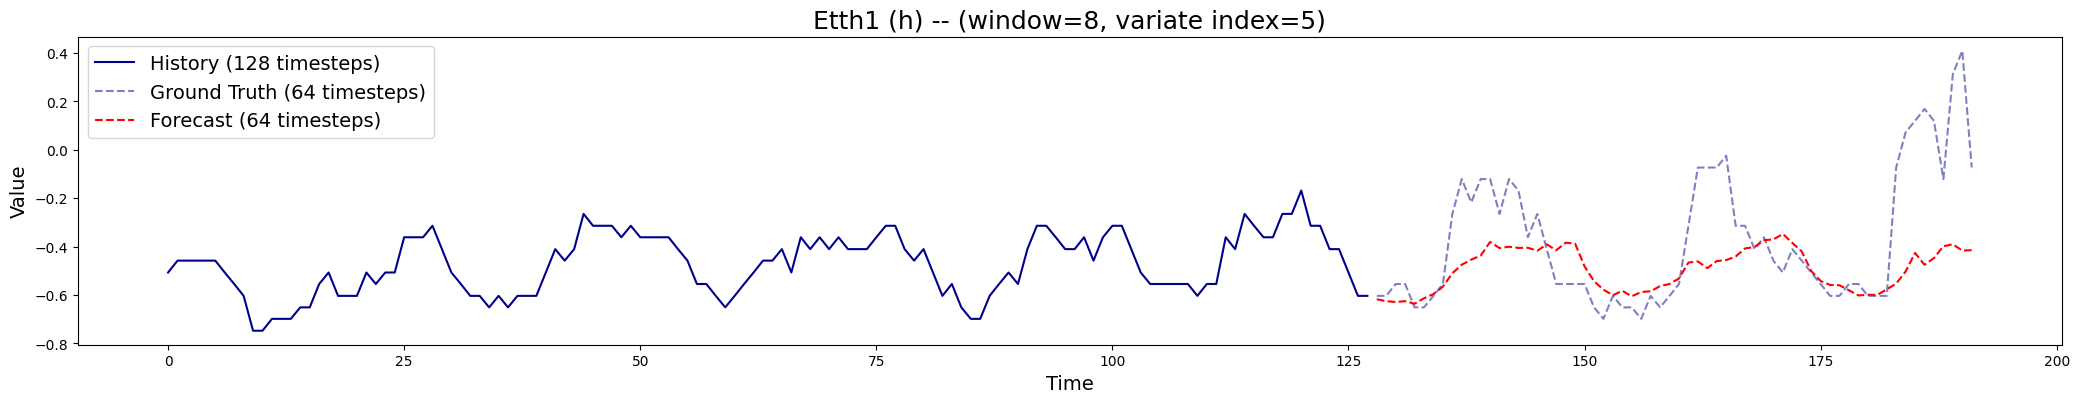

In [5]:
select = {"dataset": data_config["name"], "freq": data_config["freq"]}
visualize(
    context_len=config["context_len"],
    trues=trues,
    preds=preds,
    history=histories,
    **select,
)

### Finetune MOIRAI on ETT Dataset

In [6]:
path = "../src/uni2ts/cli/conf/finetune/model/moirai_small.yaml"
fin_config = read_yaml(path)

fin_config.keys()

dict_keys(['_target_', 'module_kwargs', 'min_patches', 'min_mask_ratio', 'max_mask_ratio', 'max_dim', 'loss_func', 'val_metric', 'lr', 'weight_decay', 'beta1', 'beta2', 'num_training_steps', 'num_warmup_steps', 'checkpoint_path'])

In [7]:
data_config_path = "../src/uni2ts/cli/conf/finetune/default.yaml"
torch_config = read_yaml(data_config_path)
ft_kwargs = prep_finetune_config(data_config_path)

In [8]:
# Number of input features to Input projection layer is the patch size used by the model
patch_size = moirai_model.model.module.in_proj.in_features_ls[0]
patch_size

16

In [9]:
# Train dataset
train_dataset = MoiraiDataset(
    name=data_config["name"],
    mode="train",
    path=data_config["path"],
    datetime_col=data_config["date_col"],
    freq=data_config["freq"],
    context_len=config["context_len"],
    horizon_len=config["horizon_len"],
    patch_size=patch_size,
    kwargs=torch_config["train_dataloader"],
)

Normalizing the dataset


In [10]:
%%time
moirai_model.finetune(train_dataset, **ft_kwargs)

KeyboardInterrupt: 

### Evaluate finetuned model

In [ ]:
%%time
metrics, trues, preds, histories = moirai_model.evaluate(test_dataset, zero_shot=False)
print(metrics)

Forecasting done....now testing
{'mse': 0.5811911945611755, 'mae': 0.490559245951836, 'mase': 0.49600410063778777, 'mape': 0.9591288573347181, 'rmse': 0.728478211880253, 'nrmse': 0.12472060751501557, 'smape': 0.7986363324135378, 'msis': 0.104133272568931, 'nd': 4.814689117694617, 'mwsq': 0.09420355769253176, 'crps': 0.7808514515877228}
CPU times: user 20.3 s, sys: 206 ms, total: 20.6 s
Wall time: 23.3 s


### Visualise forecast for a given window

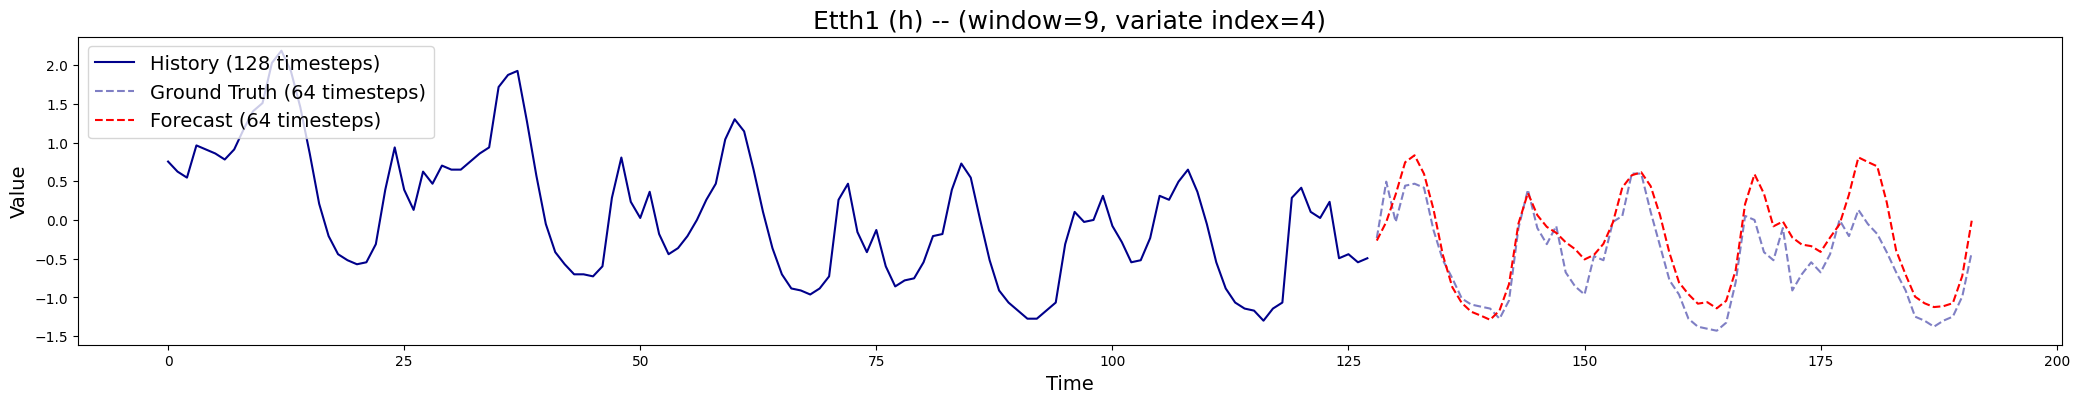

In [ ]:
visualize(
    context_len=config["context_len"],
    trues=trues,
    preds=preds,
    history=histories,
    **select,
)